# Optimization Under Uncertainty - HW1
## Jeremy Jornet - 931215248 Shani Pais - 316517218

## Question 2. Part (b)

In [ ]:
import cvxpy as cp
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import beta
from collections import defaultdict

### Subsection 1

In [8]:
def generate_graph(n, seed=248):
    np.random.seed(seed)
    G = nx.complete_graph(n, create_using=nx.DiGraph())
    E = [(i, j) for i in range(n) for j in range(n) if i != j]
    mu = { (i,j): np.random.uniform(0, 10) for (i,j) in E }
    delta = { (i,j): np.random.uniform(0, mu[(i,j)]) for (i,j) in E }
    return G, E, mu, delta

def solve_robust_min_cost_flow(n, Gamma=0, uncertainty_type='nominal', C=0.5, seed=0):
    G, E, mu, delta = generate_graph(n, seed)

    x = { (i,j): cp.Variable(nonneg=True) for (i,j) in E }
    t = cp.Variable()
    constraints = []

    if uncertainty_type == 'nominal':
        cost_expr = cp.sum([mu[i,j] * x[i,j] for (i,j) in E])
        constraints.append(cost_expr <= t)

    elif uncertainty_type == 'box':
        cost_expr = cp.sum([(mu[i,j] + delta[i,j]*Gamma) * x[i,j] for (i,j) in E])
        constraints.append(cost_expr <= t)

    elif uncertainty_type == 'ellipsoidal':
        nominal_cost = cp.sum([mu[i,j] * x[i,j] for (i,j) in E])
        norm_term = cp.norm(cp.hstack([delta[i,j] * x[i,j] for (i,j) in E]), 2)
        constraints.append(nominal_cost + Gamma * norm_term <= t)

    elif uncertainty_type == 'polyhedral':
        z = cp.Variable(nonneg=True)
        nominal_cost = cp.sum([mu[i,j] * x[i,j] for (i,j) in E])
        constraints.append(nominal_cost + Gamma * z <= t)
        for (i,j) in E:
            constraints.append(delta[i,j] * x[i,j] <= z)

    else:
        raise ValueError("Unknown uncertainty type. Choose 'nominal', 'box', 'ellipsoidal', or 'polyhedral'.")

    # Flow conservation constraints
    for node in G.nodes():
        inflow = cp.sum([x[(i,j)] for (i,j) in E if j == node])
        outflow = cp.sum([x[(i,j)] for (i,j) in E if i == node])
        if node == 0:
            constraints.append(outflow == 1)
        elif node == n - 1:
            constraints.append(inflow == 1)
        else:
            constraints.append(inflow == outflow)

    # Capacity constraints
    for (i,j) in E:
        constraints.append(x[(i,j)] <= C)

    # Solve the problem
    problem = cp.Problem(cp.Minimize(t), constraints)
    problem.solve()

    return {
        "objective_value": problem.value,
        "flow": { (i,j): x[i,j].value for (i,j) in E if x[i,j].value is not None and x[i,j].value > 1e-6 }
    }

# Run nominal and all three robust models
Gamma = 1
n = 8
for uncertainty_type in ['nominal', 'box', 'ellipsoidal', 'polyhedral']:
    result = solve_robust_min_cost_flow(n, Gamma, uncertainty_type)
    print(f"\nOptimal cost ({uncertainty_type.capitalize()}): {result['objective_value']:.4f}")
    #for (i,j), flow in result['flow'].items():
    #    print(f"  Flow from {i} to {j}: {flow:.4f}")



Optimal cost (Nominal): 5.0063

Optimal cost (Box): 7.1382

Optimal cost (Ellipsoidal): 6.5895

Optimal cost (Polyhedral): 6.4423


### Subsection 2

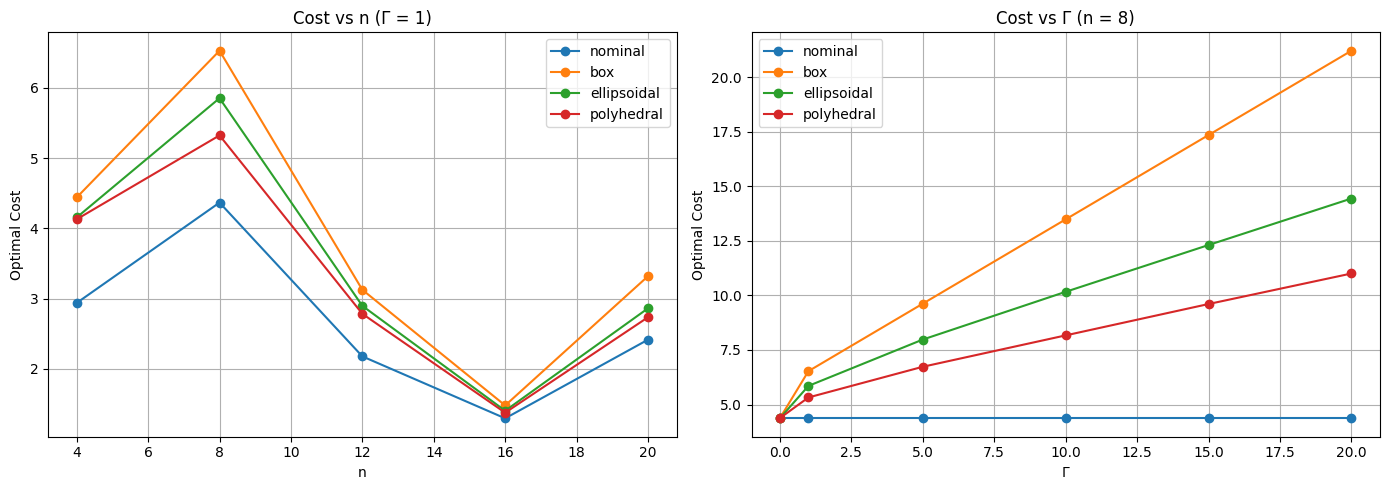

In [9]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Experiment 1: Vary n, fix Gamma = 1
n_values = [4, 8, 12, 16, 20]
Gamma_fixed = 1
results_vary_n = defaultdict(list)

for uncertainty_type in ['nominal', 'box', 'ellipsoidal', 'polyhedral']:
    for n in n_values:
        res = solve_robust_min_cost_flow(n, Gamma_fixed, uncertainty_type, seed=248)
        results_vary_n[uncertainty_type].append(res['objective_value'])

# Experiment 2: Vary Gamma, fix n = 8
Gamma_values = [0.01, 1, 5, 10, 15, 20]
n_fixed = 8
results_vary_gamma = defaultdict(list)

for uncertainty_type in ['nominal', 'box', 'ellipsoidal', 'polyhedral']:
    for Gamma in Gamma_values:
        res = solve_robust_min_cost_flow(n_fixed, Gamma, uncertainty_type, seed=248)
        results_vary_gamma[uncertainty_type].append(res['objective_value'])

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot: Cost vs n
for uncertainty in results_vary_n:
    axs[0].plot(n_values, results_vary_n[uncertainty], marker='o', label=uncertainty)
axs[0].set_title("Cost vs n (Γ = 1)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("Optimal Cost")
axs[0].legend()
axs[0].grid(True)

# Plot: Cost vs Gamma
for uncertainty in results_vary_gamma:
    axs[1].plot(Gamma_values, results_vary_gamma[uncertainty], marker='o', label=uncertainty)
axs[1].set_title("Cost vs Γ (n = 8)")
axs[1].set_xlabel("Γ")
axs[1].set_ylabel("Optimal Cost")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


**When n increases :**

*   **Nominal:** Cost decreases with n=8. This reflects more routing flexibility in larger graphs, allowing cheaper paths even without robustness.

*   **Box:** Cost increases sharply with n (peaking at n=8), then drops. The box model overestimates cost due to its conservative nature. For small graphs, fewer path options amplify worst-case costs.

*   **Ellipsoidal:** Similar pattern to box but less severe : more moderate conservatism due to Euclidean geometry.

*   **Polyhedral:** Follows the same shape, lying between ellipsoidal and nominal. It adapts better to structure than the box, showing lower cost at all n.

As n increases, the number of paths grows exponentially, offering more flexibility and enabling cheaper flow even under uncertainty. However, for small n, options are limited, and the models (especially robust ones) must guard against fewer but more extreme worst-case paths.

**When Γ increases :**

*   **Nominal:** Flat — independent of Γ since it is not impacted by uncertainty.

*   **Box:** Increases with Γ. The box set grows proportionally, leading to strong conservatism, then the cost also grows.

*  **Ellipsoidal:** Also increases with Γ, but at a lower rate due to the L2-norm. The cost grows more moderately as the ellipsoid expands.

*   **Polyhedral:** Increases with Γ, but even more slowly than ellipsoidal. In the polyhedral model, when we increase Γ, of course we allow more uncertainty but only some of the costs will change a lot, not all of them at once to preserve the constraint.

Γ controls the “size” of the uncertainty set. Larger Γ means protecting against more aggressive or higher-magnitude deviations since the Robust Counterpart is an Adversarial setting. The geometry of each uncertainty set determines how much the cost increases to remain feasible under worst-case realizations.

### Subsection 3

In [15]:
# Reuse existing function for generating the graph and cost parameters with same seed to obtain same solution as required
def generate_graph(n, seed=248):
    np.random.seed(seed)
    G = nx.complete_graph(n, create_using=nx.DiGraph())
    E = [(i, j) for i in range(n) for j in range(n) if i != j]
    mu = { (i,j): np.random.uniform(0, 10) for (i,j) in E }
    delta = { (i,j): np.random.uniform(0, mu[(i,j)]) for (i,j) in E }
    return G, E, mu, delta

# Function to solve the min-cost flow under uncertainty
def solve_robust_min_cost_flow(n, Gamma, uncertainty_type, C, seed, mu=None, delta=None):
    G, E, mu_, delta_ = generate_graph(n, seed) if mu is None else (None, None, mu, delta)

    x = { (i,j): cp.Variable(nonneg=True) for (i,j) in mu_.keys() }
    t = cp.Variable()
    constraints = []

    if uncertainty_type == 'nominal':
        cost_expr = cp.sum([mu_[(i,j)] * x[(i,j)] for (i,j) in mu_])
        constraints.append(cost_expr <= t)
    elif uncertainty_type == 'box':
        cost_expr = cp.sum([(mu_[(i,j)] + delta_[(i,j)] * Gamma) * x[(i,j)] for (i,j) in mu_])
        constraints.append(cost_expr <= t)
    elif uncertainty_type == 'ellipsoidal':
        nominal_cost = cp.sum([mu_[(i,j)] * x[(i,j)] for (i,j) in mu_])
        norm_term = cp.norm(cp.hstack([delta_[(i,j)] * x[(i,j)] for (i,j) in mu_]), 2)
        constraints.append(nominal_cost + Gamma * norm_term <= t)
    elif uncertainty_type == 'polyhedral':
        z = cp.Variable(nonneg=True)
        nominal_cost = cp.sum([mu_[(i,j)] * x[(i,j)] for (i,j) in mu_])
        constraints.append(nominal_cost + Gamma * z <= t)
        for (i,j) in mu_:
            constraints.append(delta_[(i,j)] * x[(i,j)] <= z)
    else:
        raise ValueError("Invalid uncertainty type")

    # Flow constraints
    for node in range(n):
        inflow = cp.sum([x[(i,j)] for (i,j) in mu_ if j == node])
        outflow = cp.sum([x[(i,j)] for (i,j) in mu_ if i == node])
        if node == 0:
            constraints.append(outflow == 1)
        elif node == n-1:
            constraints.append(inflow == 1)
        else:
            constraints.append(inflow == outflow)

    # Capacity constraints
    for (i,j) in mu_:
        constraints.append(x[(i,j)] <= C)

    problem = cp.Problem(cp.Minimize(t), constraints)
    problem.solve()

    flow = { (i,j): x[(i,j)].value for (i,j) in mu_ }
    return {
        "objective_value": problem.value,
        "flow": flow,
        "mu": mu_,
        "delta": delta_
    }

# Setup for simulation, with same seed to obtain same solution as required
n = 8
Gamma = 1
C = 0.5
seed = 248
models = ['nominal', 'box', 'ellipsoidal', 'polyhedral']
beta_params = [(0.5, 0.5), (2, 2), (1, 5), (5, 1)]
num_realizations = 1000

# Step 1: Generate mu and delta once
G, E, mu, delta = generate_graph(n, seed)

# Step 2: Solve each model
solutions = {}
for model in models:
    result = solve_robust_min_cost_flow(n, Gamma, model, C, seed, mu, delta)
    solutions[model] = result

# Step 3: Run simulations
percent_exceedances = defaultdict(dict)
for model in models:
    x_sol = solutions[model]["flow"]
    v = solutions[model]["objective_value"]

    for (a, b) in beta_params:
        costs_exceeding = 0
        for _ in range(num_realizations):
            c_realization = {
                (i,j): mu[(i,j)] + delta[(i,j)] * (2 * beta.rvs(a, b) - 1)
                for (i,j) in E
            }
            cTx = sum(c_realization[(i,j)] * x_sol[(i,j)] for (i,j) in E if x_sol[(i,j)] is not None)
            if cTx > v:
                costs_exceeding += 1

        percent = 100.0 * costs_exceeding / num_realizations
        percent_exceedances[model][f"Beta({a},{b})"] = percent

# Convert to DataFrame and display
results_df = pd.DataFrame(percent_exceedances).T
results_df.index.name = "Model"
results_df.reset_index(inplace=True)
results_df


,Model,"Beta(0.5,0.5)","Beta(2,2)","Beta(1,5)","Beta(5,1)"
0,nominal,50.9,49.3,1.1,99.1
1,box,0.0,0.0,0.0,0.0
2,ellipsoidal,9.2,0.4,0.0,90.8
3,polyhedral,20.4,11.4,0.0,99.5




*   **Nominal model:** Since it does not account for uncertainty, the optimal solution is frequently suboptimal when the true costs vary, especially for symmetric distributions like Beta(0.5, 0.5) or Beta(2, 2) where we can observe violation rates around 50%. The optimal solution is even more suboptimal under skewed ones like Beta(5, 1), where the violation rate reaches over 99%. This confirms that ignoring uncertainty leads to poor performance across most realizations. This shows that nominal optimization is risky in practice when uncertainty comes into play.

*   **Box model:** Geometrically, the box contains all possible deviations within its bounds, covering the full range of each uncertain cost component. As a result, the box model always guarantees feasibility, with 0% violation in every distribution but at the cost of being overly conservative, as it protects against all extreme combinations of deviations.

*   **Ellipsoidal model:** With a Euclidean-ball geometry, this model captures most typical deviations when the distribution is symmetric or light-tailed, it leads to relatively low violation rates for them, though not zero like the box. However, it fails under distributions not symmetric like Beta(5, 1), where many realizations lie outside the ellipsoid along a single dominant axis, resulting in a high 90.8% violation rate. The Ellipsoidal model seems to provides a good tradeoff when the uncertainty is balanced but loses reliability when the uncertainty is pushed in the same direction.

*   **Polyhedral model:** This model defines a budgeted uncertainty set that allows some components to deviate while limiting the overall deviation (sum of absolute values). It provides a compromise between robustness and conservativeness, performing reasonably well for symmetric distributions, but struggles under heavily skewed distributions like Beta(5,1), where violations can approach those of the nominal model.





## Problem 3
### Part C

Part (c): Solving robust optimization problem for different values of r...


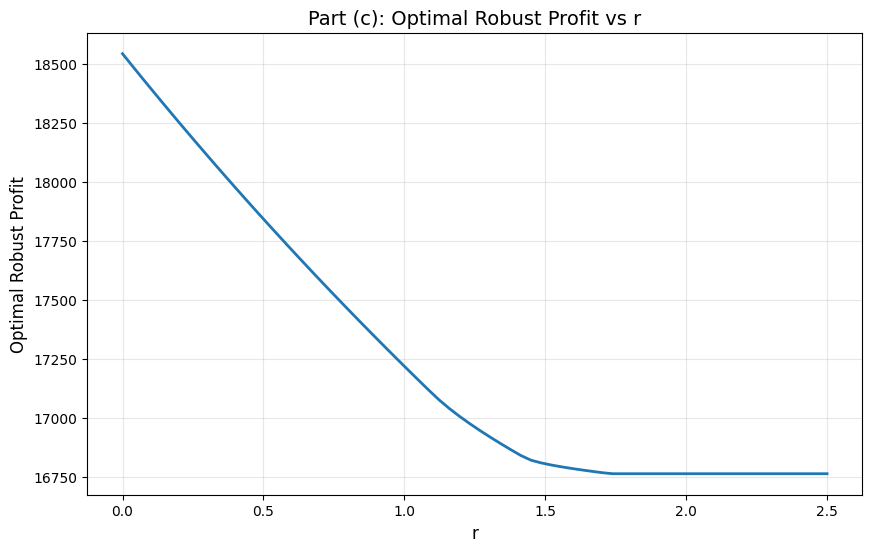

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# Part (c): Implementation and solving the robust optimization problem

# Parameters
c = np.array([12, 20, 18, 40])
q = np.array([1, 1])
xi_0 = np.array([4, 9, 7, 10, 1, 1, 3, 40, 6000, 4000])
b_diag = np.array([1/2, 1, 1, 1, 1/5, 1/5, 1/2, 4, 300, 150])
B = np.diag(b_diag)

# Define matrices S1, S2, S3, S4 from part (a)
S1 = np.zeros((5, 10))
S1[0, 0] = q[0]
S1[1, 1] = q[0]
S1[2, 2] = q[0]
S1[3, 3] = q[0]
S1[4, 8] = q[0]

S2 = np.zeros((5, 10))
S2[0, 4] = q[1]
S2[1, 5] = q[1]
S2[2, 6] = q[1]
S2[3, 7] = q[1]
S2[4, 9] = q[1]

S3 = S1 + S2
S4 = np.zeros((5, 10))

S_matrices = [S1, S2, S3, S4]

# Define the A matrix for box constraints
A = np.vstack([np.eye(10), -np.eye(10)])

def solve_robust_problem(r):
    """Solve the robust optimization problem for a given value of r"""

    # Variables
    x = cp.Variable(5)
    z = cp.Variable()
    lambda_vars = [cp.Variable(20, nonneg=True) for _ in range(4)]
    mu_vars = [cp.Variable(10, nonneg=True) for _ in range(2)]
    gamma_vars = [cp.Variable(10, nonneg=True) for _ in range(2)]

    # Objective
    objective = cp.Minimize(-c.T @ x[:4] + z)

    # Constraints
    constraints = []

    # Constraints on x
    constraints += [x[:4] >= 0]
    constraints += [x[4] == -1]

    # Objective constraints
    for j in range(4):
        constraints += [x @ S_matrices[j] @ xi_0 + cp.sum(lambda_vars[j]) <= z]
        constraints += [A.T @ lambda_vars[j] == B @ S_matrices[j].T @ x]
        constraints += [lambda_vars[j] >= 0]

    # Feasibility constraints
    for j in range(2):
        constraints += [
            r * cp.norm(mu_vars[j] - gamma_vars[j] - (1/q[j]) * B @ S_matrices[j].T @ x) +
            (1/q[j]) * x @ S_matrices[j] @ xi_0 + cp.sum(mu_vars[j]) + cp.sum(gamma_vars[j]) <= 600
        ]
        constraints += [mu_vars[j] >= 0]
        constraints += [gamma_vars[j] >= 0]

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Return optimal x and the actual profit value (not the negative objective)
    actual_profit = c @ x.value[:4] - z.value if x.value is not None else None
    return x.value, actual_profit

# Solve for different values of r
r_values = np.linspace(0, 2.5, 70)
optimal_x_values = []
optimal_profits = []

print("Part (c): Solving robust optimization problem for different values of r...")
for i, r in enumerate(r_values):
    x_opt, profit_val = solve_robust_problem(r)
    optimal_x_values.append(x_opt)
    optimal_profits.append(profit_val)

# Plot optimal profit vs r for part (c)
plt.figure(figsize=(10, 6))
plt.plot(r_values, optimal_profits, linewidth=2)
plt.xlabel('r', fontsize=12)
plt.ylabel('Optimal Robust Profit', fontsize=12)
plt.title('Part (c): Optimal Robust Profit vs r', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


### Part d


Part (d): Generating realizations and analyzing feasibility...
Checking feasibility for different values of r...


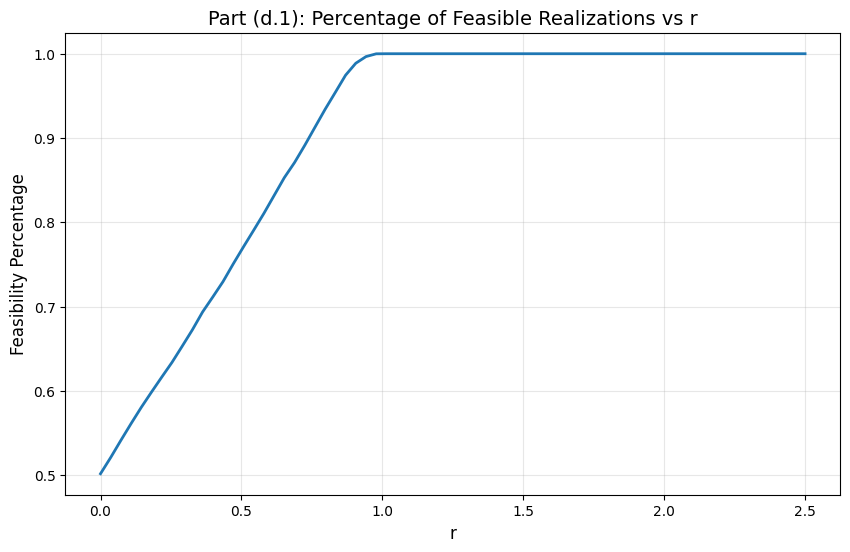

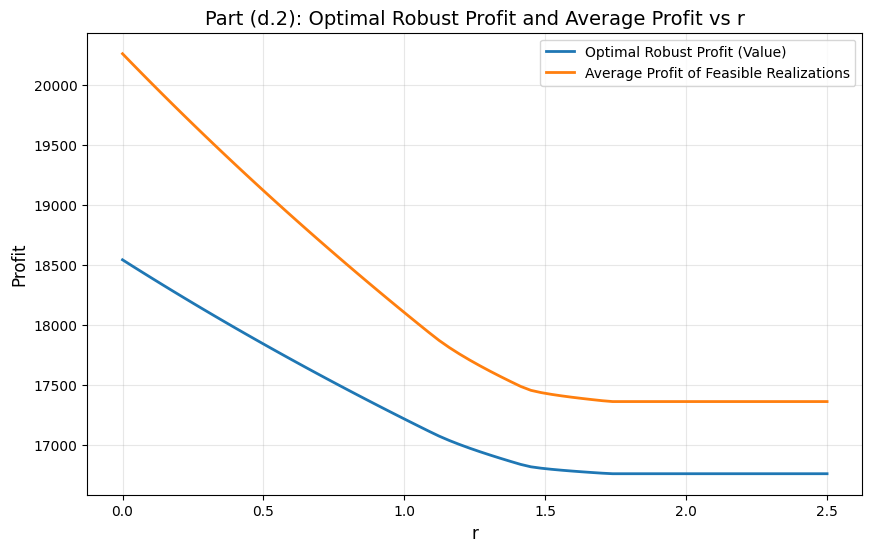

In [2]:

# Part (d): Generating realizations and checking feasibility

print("\nPart (d): Generating realizations and analyzing feasibility...")

def generate_realizations(n_samples=10000):
    """Generate random realizations of uncertain parameters"""

    # h1 ~ truncated normal(6000, sqrt(100)) on [5700, 6300]
    a1, b1 = (5700 - 6000) / np.sqrt(100), (6300 - 6000) / np.sqrt(100)
    h1_samples = truncnorm.rvs(a1, b1, loc=6000, scale=np.sqrt(100), size=n_samples)

    # h2 ~ truncated normal(4000, sqrt(50)) on [3850, 4150]
    a2, b2 = (3850 - 4000) / np.sqrt(50), (4150 - 4000) / np.sqrt(50)
    h2_samples = truncnorm.rvs(a2, b2, loc=4000, scale=np.sqrt(50), size=n_samples)

    # t1 components ~ Uniform distributions
    t1_samples = np.column_stack([
        np.random.uniform(3.5, 4.5, n_samples),
        np.random.uniform(8, 10, n_samples),
        np.random.uniform(6, 8, n_samples),
        np.random.uniform(9, 11, n_samples)
    ])

    # t2 components ~ Uniform distributions
    t2_samples = np.column_stack([
        np.random.uniform(0.8, 1.2, n_samples),
        np.random.uniform(0.8, 1.2, n_samples),
        np.random.uniform(2.5, 3.5, n_samples),
        np.random.uniform(36, 44, n_samples)
    ])

    return t1_samples, t2_samples, h1_samples, h2_samples

# Generate realizations
t1_samples, t2_samples, h1_samples, h2_samples = generate_realizations()

# Check feasibility for each value of r
feasibility_percentages = []
average_profits = []

print("Checking feasibility for different values of r...")
for i, r in enumerate(r_values):

    x_opt = optimal_x_values[i][:4]  # Only take the first 4 components

    # Check feasibility for each realization
    feasible_count = 0
    profits = []

    for sample_idx in range(10000):
        # Check constraints
        constraint1 = np.dot(t1_samples[sample_idx], x_opt) - h1_samples[sample_idx]
        constraint2 = np.dot(t2_samples[sample_idx], x_opt) - h2_samples[sample_idx]

        if constraint1 <= 600 and constraint2 <= 600:
            feasible_count += 1
            # Calculate profit for feasible solutions
            profit = np.dot(c, x_opt)
            profits.append(profit)

    feasibility_percentage = feasible_count / 10000
    feasibility_percentages.append(feasibility_percentage)

    if profits:
        average_profits.append(np.mean(profits))
    else:
        average_profits.append(0)

# Plot feasibility percentage vs r for part (d.1)
plt.figure(figsize=(10, 6))
plt.plot(r_values, feasibility_percentages, linewidth=2)
plt.xlabel('r', fontsize=12)
plt.ylabel('Feasibility Percentage', fontsize=12)
plt.title('Part (d.1): Percentage of Feasible Realizations vs r', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot optimal robust profit and average profit vs r for part (d.2)
plt.figure(figsize=(10, 6))
plt.plot(r_values, optimal_profits, linewidth=2, label='Optimal Robust Profit (Value)')
plt.plot(r_values, average_profits, linewidth=2, label='Average Profit of Feasible Realizations')
plt.xlabel('r', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Part (d.2): Optimal Robust Profit and Average Profit vs r', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()
